<a href="https://colab.research.google.com/github/frank1ma/FOID-Net/blob/main/Shared_foidnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOID-Net
## Identification of linear flat output for two-degree-of-freedom mechanical systems 

Code by Shangjie Frank Ma - Nov.2021

---


The code below uses APIs from Tensorflow 2.7.0 to build neural network to identify the linear flat ouput for 2DoF single-input Mechanical Systems. The layers are all linear without bias terms. 

The idea is based on that fact that all states and inputs are linear functions of flat output and its time derivatives, the order of which is up to the dimension of state space. The trial flat output candidate functions will be tested to construct a set of coordinates to recover the original states.

---
**In the next cell**, three linear layers, Linear, Linear1, Linear2, are designed to represent flat ouput layer, state-output layer and mirror layer. They are all initialized by 'random normal'. Function 'GenDerivSigArr' gives the derivatives of intput 'u' up to 4-th order and so does Function 'GenDerivSig'. The difference is that 'GenDerivSigArr' returns the array of first two states but 'GenDerivSig' returns full states as Tensor. 


In [ ]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as pl  # matplotlib library for plotting 
import tensorflow.keras as keras # import Keras for neural network building
from tensorflow.keras import layers


def GenDerivSigArr(u,n_cut,r):
  # GenDerivSigArr : generate array for filtered signal and derivatives
  # SS equations for G = r^4/(s+r)^4 
  # u : input signal, n_cut: ignore first n_cut number of elements in results
  # r : number to tune in G
  # return numpy array

    dt = 0.001
    len_t = u.shape[0]

    x1,x2,x3,x4 =np.zeros(len_t),np.zeros(len_t),np.zeros(len_t),np.zeros(len_t)
    # set initial value to zero
    x1[0],x2[0],x3[0],x4[0]=0,0,0,0

    for i in range(len_t-1):   # G = r^4/(s+r)^4
        x1[i+1]=x1[i]+x2[i]*dt
        x2[i+1]=x2[i]+x3[i]*dt
        x3[i+1]=x3[i]+x4[i]*dt
        x4[i+1]=x4[i]+(-r*(r*(r*(r*(x1[i]-u[i])+4*x2[i])+6*x3[i])+4*x4[i]))*dt
    s = np.array([x1[n_cut:],x2[n_cut:]])
    return s

def GenDerivSig(u,n_cut,r):
  # GenDerivSigArr : generate tensor for filtered signal and derivatives up to 
  # 4-th order, SS equations for G = r^4/(s+r)^4 
  # u : input signal, n_cut: ignore first n_cut number of elements in results
  # r : number to tune in G
  # return tf.tensor

    dt = 0.001
    len_t = u.shape[0]
    x1,x2,x3,x4 =np.zeros(len_t),np.zeros(len_t),np.zeros(len_t),np.zeros(len_t)
    # set initial value to zero
    x1[0],x2[0],x3[0],x4[0]=0,0,0,0

    for i in range(len_t-1):
        x1[i+1]=x1[i]+x2[i]*dt
        x2[i+1]=x2[i]+x3[i]*dt
        x3[i+1]=x3[i]+x4[i]*dt
        x4[i+1]=x4[i]+(-r*(r*(r*(r*(x1[i]-u[i])+4*x2[i])+6*x3[i])+4*x4[i]))*dt
    s = tf.constant([x1[n_cut:],x2[n_cut:],x3[n_cut:],x4[n_cut:]],dtype='float32')
    return s


class Linear(keras.layers.Layer):
    """y = w.x """

    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        # create weights 
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            #initializer=tf.keras.initializers.Constant([0.1051   ,0.0704   ,-0.0024  ,-0.0016]),
            #trainable=False,
            initializer="random_uniform",
            trainable=True,
        )

    def call(self, inputs):
        #return inputs * weights y = w*x
        # can specify activation functions if needed
        # return tensor
        return tf.matmul(inputs,self.w)

class Linear1(keras.layers.Layer):
    """y = w.x """

    def __init__(self, units=32):
        super(Linear1, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            #initializer=tf.keras.initializers.Constant(tf.constant([6.5001,4.5,2.5,-3.4079,-1,1.5],shape=(3,2))),
            #trainable=False,
            initializer="random_normal",
            trainable=True,
            
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

class Linear2(keras.layers.Layer):
    """y = w.x """

    def __init__(self, units=32):
        super(Linear2, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            #initializer=tf.keras.initializers.Constant(tf.constant([0.1051,0.0072,-0.2990,-0.7008, 0.0704 ,-0.0104,0.4318,1.10122,-0.0024,0.0997,0.2336,0.2317
           #                                                        , -0.0016,0.0664,0.1557,0.8212],shape=(4,4))),
            #trainable=False,
            initializer="random_normal",
            trainable=True,
            
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

# In this cell we import data from Matlab. 
If needed, python code can be written to 
generate data as well. Data are rearranged into numpy array as d1 to d4. We can change the batch size of each output. 

Here I use whole data sequence to train. So batch size is full size. 'array_split' function from numpy can let you split the data to several pieces and feed to NN. 

In the for loop, data batches are assembled into list 'data'. The shape is N x 4. This is customizable. We can have different coding here to prepare the data. 

In [ ]:
import scipy.io as si
from matplotlib import pyplot as pl

# import matlab data 
# it is a 2xN matrix or 4xN matrix, up to if derivatives of first two states are
# given or not 
mat1 = si.loadmat('inputNet_noise_80_noise_nonlinear')
output1 = mat1['inputNet'][0]
output2 = mat1['inputNet'][1]
output3 = mat1['inputNet'][2]
output4 = mat1['inputNet'][3]

d1 = np.array_split(output1[:],1)
d2 = np.array_split(output2[:],1)
d3 = np.array_split(output3[:],1)
d4 = np.array_split(output4[:],1)

data = []
for i in range(len(d1)):
    data.append(np.transpose(np.array([d1[i],d2[i],d3[i],d4[i]])))
print(data[0].shape)

(20000, 4)


# In this cell we define the layers in FOID-Net. 

L1 is flat output layer, L2 is state-ouput layer, L4 is mirror layer.
L2 is shared to recover the states. 

The inputs are defined by 'input_sys', 'input_sys2', 'input_sys4' respectively. The sizes are 4,3 and 4. 

L1,L2,L4 are objects created from 3 classes we defined before. They are initialized with number of units in each layer, which are 1,2 and 4. We take each output of neuron as the one output of the layer. Therefore L1 has 1 output, L2 has 2 outputs, and L4 has 4 outputs 

In [ ]:
input_sys = keras.Input(shape=(4,))

input_sys2 = keras.Input(shape=(3,))

input_sys4 = keras.Input(shape=(4,))

L1 =Linear(1)
L2 =Linear1(2)
L4 =Linear2(4)

# form layer,input 'input_sys', output 'linear_layer1'
# L1, L2 ,L4 are objects of layer. 
linear_layer1 = L1(input_sys)   
linear_layer2 = L2(input_sys2)
linear_layer4 = L4(input_sys4)


loss_fn = tf.keras.losses.MeanSquaredError()  # loss function MSE - API of keras 

# connect input_sys to linear_layer1 to form a model
encoder = keras.Model(input_sys,linear_layer1)  
decoder1 = keras.Model(input_sys2,linear_layer2)
encoder2 =keras.Model(input_sys4,linear_layer4)

# In this cell, we do data preprocessing.

The value of r is reassigned according to the signals.
s1 to s4 are the original signals incoming.

They are 4 states, written by x1,x2,̇x1,̇x2. 

In actual implementation, we take few order of derivatives of x1,x2,x1dot,x2dot in advance and adopt the linear combination to construct the flat candidate function y, and its derivatives,̇y,̈y,y^(3).

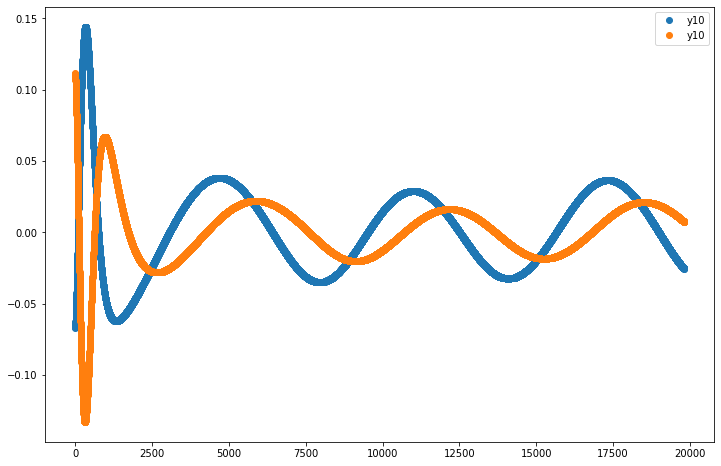

In [ ]:
epochs = 100000
n_cut = 200
r = 10


s1 = GenDerivSig(data[0][:,0],n_cut,r)
#print(s1)
s2 = GenDerivSig(data[0][:,1],n_cut,r)
s3 = GenDerivSig(data[0][:,2],n_cut,r)
s4 = GenDerivSig(data[0][:,3],n_cut,r)
s10 = np.reshape(s1[0,:],(data[0].shape[0]-n_cut,1))
s20 = np.reshape(s2[0,:],(data[0].shape[0]-n_cut,1))
s30 = np.reshape(s3[0,:],(data[0].shape[0]-n_cut,1))
s40 = np.reshape(s4[0,:],(data[0].shape[0]-n_cut,1))

s11 = np.reshape(s1[1,:],(data[0].shape[0]-n_cut,1))
s21 = np.reshape(s2[1,:],(data[0].shape[0]-n_cut,1))
s31 = np.reshape(s3[1,:],(data[0].shape[0]-n_cut,1))
s41 = np.reshape(s4[1,:],(data[0].shape[0]-n_cut,1))

s12 = np.reshape(s1[2,:],(data[0].shape[0]-n_cut,1))
s22 = np.reshape(s2[2,:],(data[0].shape[0]-n_cut,1))
s32 = np.reshape(s3[2,:],(data[0].shape[0]-n_cut,1))
s42 = np.reshape(s4[2,:],(data[0].shape[0]-n_cut,1))

s13 = np.reshape(s1[3,:],(data[0].shape[0]-n_cut,1))
s23 = np.reshape(s2[3,:],(data[0].shape[0]-n_cut,1))
s33 = np.reshape(s3[3,:],(data[0].shape[0]-n_cut,1))
s43 = np.reshape(s4[3,:],(data[0].shape[0]-n_cut,1))

x0 = tf.concat([s10,s20,s30,s40],1) # x0 filtered signal
x1 = tf.concat([s11,s21,s31,s41],1) # x1 first-order
x2 = tf.concat([s12,s22,s32,s42],1) # x2 second-order
x3 = tf.concat([s13,s23,s33,s43],1) # x3 third-order 

pl.figure(figsize=(12,8))
pl.plot(x3.numpy()[:,0:2],'o',label='y10')
#pl.plot(data[0][n_cut:,2:4],'b.',label='data')
pl.legend()
pl.show()
#print(data[0][n_cut:,:])
#print(x0)


# In this cell, we initialize the weights of L1,L2,L4 manually. 

In the **FIRST TIME** running, we need to **COMMENT this cell OUT**.

When we need to initialize the weights manully with intermediate results, they can be reassigned to different values. Run the cell before you run next one. 


In [ ]:
min_L1w = tf.Variable(np.array([[3.1899514],
 [2.2163947],
 [  0    ],
 [ 0     ]], dtype='float32'))
min_L2w=tf.constant(np.array([[0.21257421 , 0.14523529 ],
 [ 0.07829231 ,-0.11268171],
 [-0.03349997 , 0.04821541]], dtype='float32'))
min_L4w=tf.constant(np.array([[3.1899936e+00 ,-1.1735497e-03 ,-9.6221581e+00 ,-2.2491007e+01],
 [2.2163947e+00 ,-4.1813734e-03 , 1.4020177e+01 , 3.2753090e+01],
 [-1.4047300e-06 , 3.1867211e+00 , 7.4214792e+00 , 7.7296705e+00],
 [ -7.6989112e-05 , 2.2217317e+00 , 5.2361617e+00 , 2.6317118e+01]],dtype='float32'))


L1.w.assign(min_L1w)
L2.w.assign(min_L2w)
L4.w.assign(min_L4w)

<tf.Variable 'UnreadVariable' shape=(4, 4) dtype=float32, numpy=
array([[ 3.1899936e+00, -1.1735497e-03, -9.6221581e+00, -2.2491007e+01],
       [ 2.2163947e+00, -4.1813734e-03,  1.4020177e+01,  3.2753090e+01],
       [-1.4047300e-06,  3.1867211e+00,  7.4214792e+00,  7.7296705e+00],
       [-7.6989112e-05,  2.2217317e+00,  5.2361617e+00,  2.6317118e+01]],
      dtype=float32)>

# In this cell we implement training.
The for loop at Line 17 defines the whole training loop. Second for loop at Line 23 generates a number-data duo if there are more than one batch. Here I just have one batch so it is not necessary but kept for future use. 



In [ ]:
lr = 0.0001 #0.5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

flag =0  # control the value of last two weights of L1

l_val_loss =[]
l_val_loss2 =[]
l_loss1 =[]
l_loss7 =[]
l_loss5 =[]
l_loss2 =[]
l_ratio = []
l_L1w = []
l_L2w = []
l_L4w = []

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step, x in enumerate(data):
        with tf.GradientTape(persistent=True) as tape: 
           
            if flag == 1: # if flag, we constrain the last two weights of L1
                L1.w[2:4].assign(tf.constant([0,0],shape=(2,1),dtype='float32'))

            s0 = tf.matmul(x0,L1.w)       # compute flat candidate function y
                                          # y = L1.w * s0 
             
            s1 = tf.matmul(x1,L1.w)       # compute first-order deriv of y
                                          # ydot = L1.w * s1 
            s2 = tf.matmul(x2,L1.w)       
            s3 = tf.matmul(x3,L1.w)

            y2input = tf.concat([s0,s1,s2],1) # form input for first 2 states
                                              # in state-output layer
            y3input = tf.concat([s1,s2,s3],1) # form input for last 2 states
                                              # in state-output layer
            
            y2 = decoder1(y2input) # Compute first 2 outputs of SO Layer
            y3 = decoder1(y3input) # Compute last 2 outputs of SO Layer
            y4 = encoder2(x0)      # Compute Wm * x0, Wm is weights of L4, L4.w
            #print(tf.matmul(tf.transpose(L4.w),atf))

            a = np.zeros(shape=(4,4)) 
            a[0:3,0:2] = L2.w.numpy()
            a[1:4,2:4] = L2.w.numpy()
            atf = tf.Variable(a,dtype='float32') # construct Wp matrix
                           
            
           
            # pl.figure(figsize=(5,4),dpi=180)
            # pl.plot(x0[:,3])
            # pl.plot(tf.concat([y2,y3],1)[:,3])

            loss1 = loss_fn(x0,tf.concat([y2,y3],1))  #L1
            loss4 = loss_fn(tf.matmul(y2,L1.w[0:2])+tf.matmul(y3,L1.w[2:4]),tf.matmul(x0,L1.w)) # this is trivial to add into loss function  
            loss2 = loss_fn(tf.reshape(tf.linalg.inv(atf)[:,0],(4,1)),L1.w) #L4 
            loss5 = loss_fn(tf.matmul(L4.w,atf),tf.eye(4)) #L3
            loss7 = loss_fn(y4,tf.concat([s0,s1,s2,s3],1)) #L2
            loss6 = loss_fn(L1.w,L4.w[:,0:1])
            loss  = loss1+loss2+loss4+loss5+loss6+loss7

        gradients1 = tape.gradient(loss, L1.trainable_weights) # compute gradiant 
        gradients2 = tape.gradient(loss, L2.trainable_weights)
        gradients4 = tape.gradient(loss, L4.trainable_weights)
            
        optimizer.apply_gradients(zip(gradients1, L1.trainable_weights)) # update weights in L1
        
        
        if flag == 1:                                                    # force to contrain weights in L1 if needed.
                                                                         # preventing last two weights in L1 to update
            L1.w[2:4].assign(tf.constant([0,0],shape=(2,1),dtype='float32'))

        
        optimizer.apply_gradients(zip(gradients2, L2.trainable_weights)) # update weights in L2
        optimizer.apply_gradients(zip(gradients4, L4.trainable_weights)) # update weights in L4

        val_loss = float(loss)                                           # plot and record 
        l_val_loss.append(val_loss)  # loss with loss4 above
        l_val_loss2.append(loss1+loss7+loss5+loss2)  # loss we consider in paper
        l_ratio.append(float(L1.w.numpy()[0]/L1.w.numpy()[1]))
        l_L1w.append(L1.w.numpy())
        l_L2w.append(L2.w.numpy())
        l_L4w.append(L4.w.numpy())
        l_loss1.append(float(loss1))
        l_loss7.append(float(loss7))
        l_loss5.append(float(loss5))
        l_loss2.append(float(loss2))
        a=np.argmin(l_val_loss)
        min_loss = l_val_loss[a]
        min_loss_p= l_val_loss2[a]
        min_ratio = l_ratio[a]
        min_L1w = l_L1w[a]
        min_L2w = l_L2w[a]
        min_L4w = l_L4w[a]
        min_loss1 =l_loss1[a]
        min_loss7 =l_loss7[a]
        min_loss5 =l_loss5[a]
        min_loss2 =l_loss2[a]
        print('best ratio for now:',min_ratio,'pos',a,'L1[0]',min_L1w[0],'L1[1]',min_L1w[1],'ratio now is:',l_ratio[-1])
        print('min loss now:',min_loss,'loss now:', val_loss)
        #print('L2.w',L2.w,'L4.w',L4.w)
        # pl.figure(1)
        # pl.plot(float(1/L1.w.numpy()[0]),val_loss,'.')
        # if step % 4 == 0 :
        #     print(
        #         "Training loss : %.3e"
        #         % (val_loss),
        #         "Training loss1 :%.3e"
        #         % (float(loss1)),
        #         "Training loss2 : %.3e"
        #         % (float(loss2)),
        #         "Training loss3 : %.3e"
        #         #% (float(loss3)),
        #         #"Training loss4 : %.3e"
        #         % (float(loss4)),
        #         "Training loss5 : %.3e"
        #         % (float(loss5)),
        #         "Training loss6 : %.3e"
        #         % (float(loss6)),
        #         "Training loss7 : %.3e"
        #         % (float(loss7)),
        #         "\nL1.W : ",L1.w.numpy()[0],L1.w.numpy()[1],L1.w.numpy()[2],L1.w.numpy()[3]
                
        #     )


Start of epoch 0
best ratio for now: 1.439276099205017 pos 0 L1[0] [3.190046] L1[1] [2.216424] ratio now is: 1.439276099205017
min loss now: 9.291399692301638e-06 loss now: 9.291399692301638e-06

Start of epoch 1
best ratio for now: 1.439276099205017 pos 0 L1[0] [3.190046] L1[1] [2.216424] ratio now is: 1.4392199516296387
min loss now: 9.291399692301638e-06 loss now: 9.920424417941831e-06

Start of epoch 2
best ratio for now: 1.439276099205017 pos 0 L1[0] [3.190046] L1[1] [2.216424] ratio now is: 1.439246416091919
min loss now: 9.291399692301638e-06 loss now: 1.1868484762089793e-05

Start of epoch 3
best ratio for now: 1.439276099205017 pos 0 L1[0] [3.190046] L1[1] [2.216424] ratio now is: 1.4392379522323608
min loss now: 9.291399692301638e-06 loss now: 1.354795131192077e-05

Start of epoch 4
best ratio for now: 1.439276099205017 pos 0 L1[0] [3.190046] L1[1] [2.216424] ratio now is: 1.4391988515853882
min loss now: 9.291399692301638e-06 loss now: 1.7266920622205362e-05

Start of epoch

KeyboardInterrupt: ignored

# This cell we print the best result in current training loop. 

In [ ]:
print(min_loss_p)
print(min_loss1)
print(min_loss7)
print(min_loss5)
print(min_loss2)
a=np.argmin(l_val_loss) # index of minimum 
print(l_ratio[a])
print(a) 

# In this cell we print the weights of best L1,L2,L4 according to loss 

atf is resulted Wp matrix, min_L4w is the Wm.

In [ ]:
print(min_L1w)
print(min_L2w)
print(min_L4w)
a = np.zeros(shape=(4,4))
a[0:3,0:2] = min_L2w
a[1:4,2:4] = min_L2w
atf = tf.Variable(a,dtype='float32')
print('atf',tf.transpose(atf))
print('min_L4w:',tf.transpose(min_L4w))

# This cell is used for plotting

In [ ]:
ll = []
for i in l_val_loss2:
  ll.append(i.numpy())

pl.rcParams["font.size"] = 14

fig, ax1 = pl.subplots()
color = 'tab:red'
ax1.plot(range(0,10000),l_ratio[0:10000],label='Ratio')
ax1.set_ylim(-5,5)
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Ratio')
ax2 = ax1.twinx()
color = 'tab:blue'
# pl.figure(1)
# ax2.plot(range(1,65000),l_loss1[1:2500],label='loss function 1')
# ax2.plot(range(1,65000),l_loss7[1:2500],label='loss function 2')
# ax2.plot(range(1,2500),l_loss5[1:2500],label='loss function 3')
ax2.plot(range(0,10000),ll[0:10000],'r.-',label='Loss function',markevery=100)
ax2.set_ylim(0,0.5)
ax2.set_ylabel('MSE')
ax1.legend(loc='lower right')
ax2.legend()
#fig.set_size_inches(18.5, 10.5)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
pl.show()
fig.savefig('last1.eps', format='eps')


fig2, ax3 = pl.subplots()
color = 'tab:red'
ax3.plot(range(9500,10000),l_ratio[9500:10000],label='Ratio')
ax3.set_ylim(1.5,1.65)
ax3.set_xlabel('Number of epochs')
ax3.set_ylabel('Ratio')
ax4 = ax3.twinx()
color = 'tab:blue'
# pl.figure(1)
# ax2.plot(range(1,2500),l_loss1[1:2500],label='loss function 1')
# ax2.plot(range(1,2500),l_loss7[1:2500],label='loss function 2')
# ax2.plot(range(1,2500),l_loss5[1:2500],label='loss function 3')
ax4.plot(range(9500,10000),ll[9500:10000],'r',label='Loss function')
ax4.set_ylim(0,0.08)
ax4.set_ylabel('MSE')
ax3.legend(loc='upper left')
ax4.legend()
#fig.set_size_inches(18.5, 10.5)
fig2.tight_layout()  # otherwise the right y-label is slightly clipped
pl.show()
fig2.savefig('last2.eps', format='eps')
#pl.plot(range(600,650),l_ratio[600:650])
#pl.plot(range(2000,2500),l_ratio[2000:2500])
#pl.ylim(0,5e-5)